In [1]:
import sys

import mdtraj as md
import numpy as np
from hbond_elliptical_fortran import calualateHBMap, ellipticalFun, getGroups, create_bond_dict
import matplotlib.pyplot as plt
import matplotlib
from numpy import array, array_equal, allclose


In [38]:
## I am using a modified version of hbond_elliptical (hbond_elliptical_fortran) , so that I have the same r_range and theta_range as Jingyi's Fortran code

In [2]:
#This function helps us find the difference between H-bonding triplets generated from mdtraj and hbond_elliptical
def arreq_in_list(myarr, list_arrays):
    return next((True for elem in list_arrays if array_equal(elem, myarr)), False)

### The xyz file is box1movie1frame.xyz, we load it in mdtraj

In [3]:
filename = "box1movie.hbond.xyz"
traj = md.load(filename, top="init1.pdb")
L = 3.207 #box length in nm
traj = md.Trajectory(
    traj.xyz,
    traj.top,
    unitcell_lengths=np.tile(
        [L, L, L], (traj.n_frames, 1)
    ),
    unitcell_angles=np.tile(
        [90.0, 90.0, 90.0], (traj.n_frames, 1)
    ),
)


In [4]:
print ("The trajectory has {} frame".format(traj.n_frames))

The trajectory has 1 frame


### Next we need to make the selections, details can be found in the hbond_elliptical code

In [5]:
sel_oxygen_head = 'name OW' ; sel_hydrogen = 'name HW1 or name HW2' ; sel_oxygen_tail = 'name OW'; list_names_hydrogen = ["HW1", "HW2"] ; list_names_oxygen_head = ["OW"] ; list_names_oxygen_tail = ["OW"]

### The pdb file did not contain any bonding info, so we are using the create_bond_traj function from hbond_elliptical

In [6]:
dictin, top= create_bond_dict(traj, sel_oxygen_head, sel_oxygen_tail, sel_hydrogen, list_names_hydrogen, list_names_oxygen_head, list_names_oxygen_tail, bonded_pdb_provided=False, max_r_bond=0.12)

### Next we use the baker_hubbard method from mdtraj to find the number of hydrogen bonds, and the triplets forming Hbond

In [7]:
md_hbond = md.baker_hubbard(traj)

In [8]:
print("Number of H bonds from Baker-Hubbard method is {}".format(len(md_hbond)))

Number of H bonds from Baker-Hubbard method is 2091


### Now we use the hbond_elliptical to find the number of Hbonds

In [9]:

nbins_r = 200 ; nbins_a = 200 ; r_cutoff = 0.4 ; skip_every_x_frames = 1; bonded_pdb_provided = True

In [10]:
rdf_output, inter_output, map_output,hbond,hbond_time = calualateHBMap(traj, r_cutoff, nbins_r, nbins_a, skip_every_x_frames, sel_oxygen_head, sel_oxygen_tail, sel_hydrogen, list_names_hydrogen, list_names_oxygen_head, list_names_oxygen_tail, bonded_pdb_provided)

traj as 2200 bonds
da 0.004363323129985823
dr 0.001
working on 0


In [11]:
print("Number of hbonds found from hbond_elliptical is {}".format(len(hbond)))
print("mdtraj predicts {} more hbonds in the frame as compared to hbond_elliptical (1100 water molecules).".format(len(md_hbond)-len(hbond)))

Number of hbonds found from hbond_elliptical is 1940
mdtraj predicts 151 more hbonds in the frame as compared to hbond_elliptical (1100 water molecules).


In [12]:
l_md_hbond = list(md_hbond)

### In diff we store the triplets that were classified as a H-bond forming triplet in mdtraj but not in hbond_elliptical

In [13]:
diff = []

for elem in l_md_hbond:
    if arreq_in_list(elem, hbond):
        1+1
    else:
        diff.append(elem)

In [14]:
len(diff)

151

In [15]:

coords = []

for element in diff:
    dist = md.compute_distances(traj, np.array([[element[0],element[2]]]))
    angle = (md.compute_angles(traj, np.array([[element[0],element[1], element[2]]]))[0][0] - 1e-12)*180/np.pi
    
    coords.append(np.array([dist[0][0], angle]))

### We can also visualize where those points lied w.r.t. the hbond ellipse

<Figure size 432x288 with 0 Axes>

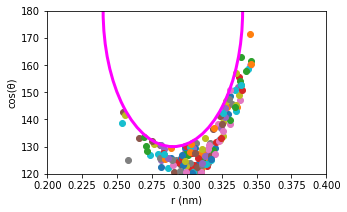

In [16]:
plt.figure()
cmap = plt.get_cmap('jet')
plt.figure(figsize=(5, 3))
plt.style.use('default')
levels = np.linspace(0,10,11)
#cs = plt.contourf(rdf_output[0], inter_output[0], map_output,levels = levels, cmap=cmap)
plt.xlabel('r (nm)')
plt.ylabel('cos(\u03B8)')

z = np.linspace(0,180/np.pi,200)
x = np.linspace(0,0.75,100)
x,z = np.meshgrid(x,z)

ellipse = matplotlib.patches.Ellipse(
        (0.29, 180), 0.05*2, 50*2, ec="magenta", facecolor="none", linewidth=3
    )
plt.gca().add_patch(ellipse)


    
plt.xlim([0.2, 0.4])
plt.ylim([120, 180])
for i, coord in enumerate(coords):
    
    plt.scatter(coord[0], coord[1])
    #print(coord,i, diff[i], ellipticalFun(coord[0], coord[1]))


### The heat map for r-theta

<Figure size 640x480 with 0 Axes>

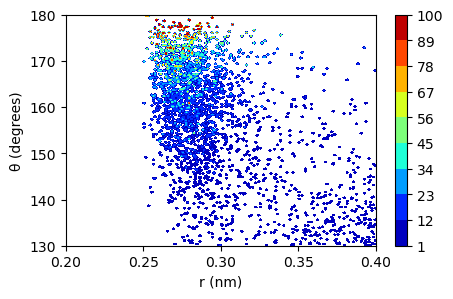

In [49]:
plt.figure() ; cmap = plt.get_cmap('jet') ; plt.figure(figsize=(5, 3)) ; plt.style.use('default'); levels = np.linspace(1,100,10) ; cs = plt.contourf(rdf_output[0], inter_output[0]*180/np.pi, map_output,levels = levels, cmap=cmap) ; plt.xlabel('r (nm)') ; plt.ylabel('\u03B8 (degrees)') ; plt.xlim([0.2, 0.4]) ; plt.ylim([130, 180]) ; plt.colorbar()

In [50]:
fortran_array = np.genfromtxt("fortran/box-1-2D-hist-0-1.dat")

In [51]:
fortran_map = np.reshape(fortran_array[:,2], (200,200)).T

### Heat map for the fortran data

<Figure size 640x480 with 0 Axes>

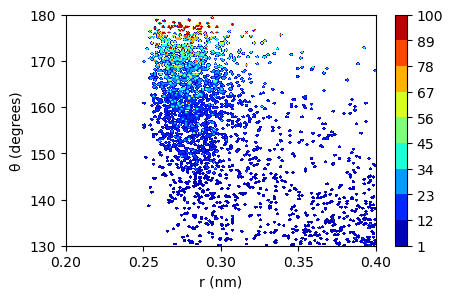

In [52]:
plt.figure() ; cmap = plt.get_cmap('jet') ; plt.figure(figsize=(5, 3)) ; plt.style.use('default'); levels = np.linspace(1,100,10) ; cs = plt.contourf(rdf_output[0], inter_output[0]*180/np.pi, fortran_map,levels = levels, cmap=cmap) ; plt.xlabel('r (nm)') ; plt.ylabel('\u03B8 (degrees)') ; plt.xlim([0.2, 0.4]) ; plt.ylim([130, 180]) ; plt.colorbar()

### Plotting the difference

<Figure size 640x480 with 0 Axes>

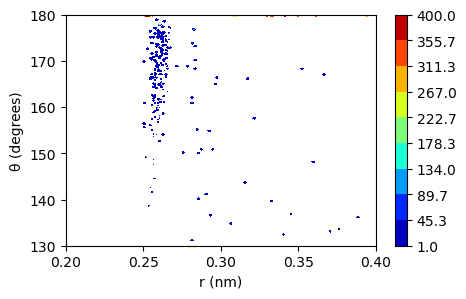

In [48]:

plt.figure() ; cmap = plt.get_cmap('jet') ; plt.figure(figsize=(5, 3)) ; 
plt.style.use('default'); levels = np.linspace(1,400,10) ; 
cs = plt.contourf(rdf_output[0], inter_output[0]*180/np.pi, (map_output-fortran_map),levels = levels, cmap=cmap) ;
plt.xlabel('r (nm)') ; plt.ylabel('\u03B8 (degrees)') ;
plt.xlim([0.2, 0.4]) ; plt.ylim([130, 180]) ;
plt.colorbar()

